In [ ]:
#!/usr/bin/env python3
"""
Assignment 1: PM_980 Dataset for Signal Classification
Student ID: 211805036
Course: Machine Learning Final Project 2024-2025

In [ ]:
This script implements signal classification using PM_980 dataset with:
- 9 classes: healthy, scratch, notchshort, notchlong, singlecutlong, singlecutshort, twocutlong, twocutshort, warped
- 8 sensor features + speed interval
- Time and frequency domain feature extraction
- Stratified 10-fold cross-validation
- Multiple ML algorithms comparison
"""

========================================================================================<br>
SECTION 1: IMPORT LIBRARIES<br>
========================================================================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from scipy import stats
from scipy.fft import fft, fftfreq
from scipy.signal import welch
import joblib
import warnings
import time
import os
import glob

In [2]:
warnings.filterwarnings('ignore')

Set random seed for reproducibility

In [3]:
RANDOM_SEED = 13
np.random.seed(RANDOM_SEED)

In [4]:
print("=" * 80)
print("PM_980 SIGNAL CLASSIFICATION PROJECT")
print("Student ID: 211805036")
print("=" * 80)

PM_980 SIGNAL CLASSIFICATION PROJECT
Student ID: 211805036


========================================================================================<br>
SECTION 2: DATA LOADING AND PREPROCESSING<br>
========================================================================================

In [5]:
def load_pm980_data(data_path='../ML_FINAL/PM980/'):
    """
    Load PM_980 dataset for signal classification
    Expected columns: Speed, Voice, Acceleration X/Y/Z, Gyro X/Y/Z, Temperature, Speed_Range
    Class labels are extracted from filenames
    """
    try:
        print(f"Loading PM_980 dataset from {data_path}...")
        
        if not os.path.exists(data_path):
            print(f"Warning: {data_path} not found. Creating dummy dataset for demonstration...")
            return create_dummy_pm980_data()
        
        all_files = glob.glob(os.path.join(data_path, "*.csv"))
        print(f"Found {len(all_files)} CSV files")
        
        if len(all_files) == 0:
            print("No CSV files found. Creating dummy dataset for demonstration...")
            return create_dummy_pm980_data()
        
        all_dataframes = []
        
        for i, file_path in enumerate(all_files):
            filename = os.path.basename(file_path)
            
            # Parse filename to extract class label
            # Format: speed_range_class1class2_environment_noise_980.csv
            parts = filename.replace('_980.csv', '').split('_')
            
            if len(parts) >= 3:
                speed_range = f"{parts[0]}_{parts[1]}"  # e.g., "100.0_110.0"
                class_combination = parts[2]  # e.g., "healthynotchlong"
                
                # Extract individual classes from combination
                class_label = extract_primary_class(class_combination)
                
                try:
                    df = pd.read_csv(file_path)
                    
                    # Rename columns to match our expected format
                    column_mapping = {
                        'Speed': 'sensor1_sound',  # Actually speed, but we'll treat as first sensor
                        'Voice': 'sensor2_voice',  # Voice/Sound sensor
                        'Acceleration X': 'sensor3_acc_x',
                        'Acceleration Y': 'sensor4_acc_y', 
                        'Acceleration Z': 'sensor5_acc_z',
                        'Gyro X': 'sensor6_gyro_x',
                        'Gyro Y': 'sensor7_gyro_y',
                        'Gyro Z': 'sensor8_gyro_z',
                        'Temperature': 'sensor9_temp',
                        'Speed_Range': 'speed_interval'
                    }
                    
                    df = df.rename(columns=column_mapping)
                    df['class_label'] = class_label
                    df['filename'] = filename
                    
                    all_dataframes.append(df)
                    
                    if (i + 1) % 50 == 0:
                        print(f"Processed {i + 1}/{len(all_files)} files...")
                        
                except Exception as e:
                    print(f"Error reading {filename}: {e}")
                    continue
        
        if all_dataframes:
            combined_df = pd.concat(all_dataframes, ignore_index=True)
            print(f"Dataset loaded successfully! Shape: {combined_df.shape}")
            print(f"Classes found: {sorted(combined_df['class_label'].unique())}")
            return combined_df
        else:
            print("No valid files found. Creating dummy dataset...")
            return create_dummy_pm980_data()
            
    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Creating dummy dataset for demonstration...")
        return create_dummy_pm980_data()

In [6]:
def extract_primary_class(class_combination):
    """
    Extract primary class from class combination string
    e.g., 'healthynotchlong' -> focus on the damage type
    """
    # Define class priorities and mappings
    damage_classes = [
        'scratch', 'notchlong', 'notchshort', 'singlecutlong', 'singlecutshort',
        'twocutlong', 'twocutshort', 'warped'
    ]
    
    class_combination_lower = class_combination.lower()
    
    # Check for damage types first
    for damage_class in damage_classes:
        if damage_class in class_combination_lower:
            return damage_class
    
    # If no damage found, check for healthy
    if 'healthy' in class_combination_lower:
        return 'healthy'
    
    # Fallback - return the original combination
    return class_combination_lower

In [7]:
def create_dummy_pm980_data():
    """Create dummy PM_980 dataset for demonstration purposes"""
    np.random.seed(RANDOM_SEED)
    
    # 9 classes as specified in assignment
    classes = ['healthy', 'scratch', 'notchshort', 'notchlong', 'singlecutlong', 
               'singlecutshort', 'twocutlong', 'twocutshort', 'warped']
    
    n_samples = 1000
    sampling_rate = 90  # Hz as specified
    
    data = []
    for i in range(n_samples):
        # Simulate sensor data (8 sensors + speed interval)
        sample = {
            'sensor1_sound': np.random.normal(0, 1),  # Sound sensor
            'sensor2_acc_x': np.random.normal(0, 2),  # Accelerometer X
            'sensor3_acc_y': np.random.normal(0, 2),  # Accelerometer Y
            'sensor4_acc_z': np.random.normal(0, 2),  # Accelerometer Z
            'sensor5_gyro_x': np.random.normal(0, 1.5),  # Gyroscope X
            'sensor6_gyro_y': np.random.normal(0, 1.5),  # Gyroscope Y
            'sensor7_gyro_z': np.random.normal(0, 1.5),  # Gyroscope Z
            'sensor8_temp': np.random.normal(25, 5),  # Temperature
            'speed_interval': np.random.choice(['low', 'medium', 'high']),
            'class_label': np.random.choice(classes)
        }
        data.append(sample)
    
    df = pd.DataFrame(data)
    print("Dummy PM_980 dataset created for demonstration")
    return df

Load data

In [8]:
data = load_pm980_data()

Loading PM_980 dataset from ../ML_FINAL/PM980/...
Found 480 CSV files
Processed 50/480 files...
Processed 100/480 files...
Processed 150/480 files...
Processed 200/480 files...
Processed 250/480 files...
Processed 300/480 files...
Processed 350/480 files...
Processed 400/480 files...
Processed 450/480 files...
Dataset loaded successfully! Shape: (206919, 12)
Classes found: ['healthy', 'notchlong', 'notchshort', 'scracth', 'singlecutlong', 'singlecutshort', 'twocutlong', 'twocutshort', 'warped']


Display basic information

In [9]:
print(f"\nDataset Info:")
print(f"Shape: {data.shape}")
print(f"Columns: {list(data.columns)}")
print(f"\nClass distribution:")
print(data['class_label'].value_counts())


Dataset Info:
Shape: (206919, 12)
Columns: ['sensor1_sound', 'sensor2_voice', 'sensor3_acc_x', 'sensor4_acc_y', 'sensor5_acc_z', 'sensor6_gyro_x', 'sensor7_gyro_y', 'sensor8_gyro_z', 'sensor9_temp', 'speed_interval', 'class_label', 'filename']

Class distribution:
class_label
twocutlong        29222
twocutshort       27252
notchshort        27022
singlecutshort    26844
notchlong         25308
warped            24724
singlecutlong     21010
healthy           14571
scracth           10966
Name: count, dtype: int64


========================================================================================<br>
SECTION 3: EXPLORATORY DATA ANALYSIS<br>
========================================================================================

In [10]:
def perform_eda(data):
    """Perform Exploratory Data Analysis"""
    print("\n" + "="*50)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*50)
    
    # Class distribution visualization
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    data['class_label'].value_counts().plot(kind='bar', color='skyblue', alpha=0.8)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Sensor correlation heatmap
    plt.subplot(1, 2, 2)
    sensor_columns = [col for col in data.columns if 'sensor' in col]
    if len(sensor_columns) > 0:
        # Convert categorical speed_interval to numeric for correlation
        data_numeric = data.copy()
        if 'speed_interval' in data_numeric.columns:
            data_numeric['speed_interval'] = data_numeric['speed_interval'].map(
                {'low': 0, 'medium': 1, 'high': 2}
            )
        
        correlation_matrix = data_numeric[sensor_columns].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)
        plt.title('Sensor Correlation Matrix')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print("\nStatistical Summary:")
    print(data.describe())


EXPLORATORY DATA ANALYSIS


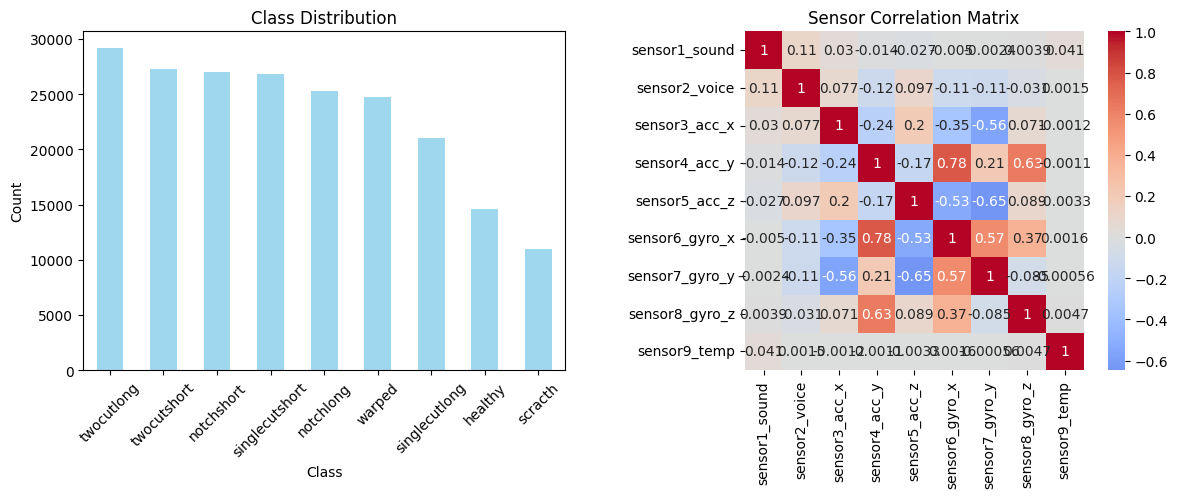


Statistical Summary:
       sensor1_sound  sensor2_voice  sensor3_acc_x  sensor4_acc_y  \
count  206919.000000  206919.000000  206919.000000  206919.000000   
mean       81.075107    1505.640743       0.073087      -0.112033   
std        28.782607     859.624450       5.649055      10.210562   
min        40.000000       0.000000     -73.840000     -79.100000   
25%        60.000000     991.000000      -0.870000      -1.220000   
50%        80.000000    1456.000000      -0.030000       0.000000   
75%       110.000000    2028.000000       0.730000       1.230000   
max       130.000000    4095.000000      80.190000      78.210000   

       sensor5_acc_z  sensor6_gyro_x  sensor7_gyro_y  sensor8_gyro_z  \
count  206919.000000   206919.000000   206919.000000   206919.000000   
mean        9.620781       -0.133516       -0.118111        0.063178   
std         8.032733       35.226606       35.583189       18.858330   
min       -78.540000     -495.500000     -440.720000     -352.100000

In [11]:
perform_eda(data)

========================================================================================<br>
SECTION 4: FEATURE ENGINEERING<br>
========================================================================================

In [12]:
def engineer_features(data):
    """Engineer features from raw sensor data - OPTIMIZED VERSION"""
    print("\n" + "="*50)
    print("FEATURE ENGINEERING (OPTIMIZED)")
    print("="*50)
    
    feature_list = []
    labels = []
    
    # Get sensor columns (excluding metadata columns)
    sensor_columns = [col for col in data.columns if 'sensor' in col]
    print(f"Sensor columns found: {sensor_columns}")
    
    # Group data by class and filename to process time series
    grouped = data.groupby(['class_label', 'filename'])
    total_groups = len(grouped)
    
    print(f"Processing {total_groups} time series...")
    
    for idx, ((class_label, filename), group) in enumerate(grouped):
        if idx % 50 == 0:  # Progress update every 50 series
            print(f"Progress: {idx}/{total_groups} ({idx/total_groups*100:.1f}%)")
        
        features = {}
        
        # Extract BASIC features for each sensor (faster)
        for sensor in sensor_columns:
            signal = group[sensor].values
            
            # Skip if signal is too short
            if len(signal) < 10:
                continue
            
            # Clean signal first
            signal = signal[~np.isnan(signal)]
            signal = signal[np.isfinite(signal)]
            
            if len(signal) == 0:
                continue
            
            # BASIC time domain features only (much faster)
            features[f"{sensor}_mean"] = np.mean(signal)
            features[f"{sensor}_std"] = np.std(signal)
            features[f"{sensor}_min"] = np.min(signal)
            features[f"{sensor}_max"] = np.max(signal)
            features[f"{sensor}_range"] = np.max(signal) - np.min(signal)
            features[f"{sensor}_energy"] = np.sum(signal**2)
            features[f"{sensor}_rms"] = np.sqrt(np.mean(signal**2))
            
            # BASIC frequency domain features only (faster)
            if len(signal) >= 4:
                try:
                    # Simple FFT analysis
                    fft_values = np.abs(fft(signal))
                    freqs = fftfreq(len(signal), 1/90)
                    
                    # Only positive frequencies
                    positive_fft = fft_values[:len(fft_values)//2]
                    positive_freqs = freqs[:len(freqs)//2]
                    
                    if len(positive_fft) > 0 and np.sum(positive_fft) > 0:
                        features[f"{sensor}_spectral_centroid"] = np.sum(positive_freqs * positive_fft) / np.sum(positive_fft)
                        features[f"{sensor}_dominant_freq"] = positive_freqs[np.argmax(positive_fft)]
                        features[f"{sensor}_total_power"] = np.sum(positive_fft)
                    else:
                        features[f"{sensor}_spectral_centroid"] = 0
                        features[f"{sensor}_dominant_freq"] = 0
                        features[f"{sensor}_total_power"] = 0
                except:
                    features[f"{sensor}_spectral_centroid"] = 0
                    features[f"{sensor}_dominant_freq"] = 0
                    features[f"{sensor}_total_power"] = 0
        
        # SIMPLIFIED cross-correlation (only between key sensors)
        if len(sensor_columns) >= 3:
            try:
                # Only correlate voice with accelerometer and gyro (most important)
                voice_signal = group['sensor2_voice'].values
                acc_x_signal = group['sensor3_acc_x'].values
                gyro_x_signal = group['sensor6_gyro_x'].values
                
                min_len = min(len(voice_signal), len(acc_x_signal), len(gyro_x_signal))
                if min_len > 10:
                    features['voice_acc_corr'] = np.corrcoef(voice_signal[:min_len], acc_x_signal[:min_len])[0,1]
                    features['voice_gyro_corr'] = np.corrcoef(voice_signal[:min_len], gyro_x_signal[:min_len])[0,1]
                    features['acc_gyro_corr'] = np.corrcoef(acc_x_signal[:min_len], gyro_x_signal[:min_len])[0,1]
                    
                    # Replace NaN correlations with 0
                    for key in ['voice_acc_corr', 'voice_gyro_corr', 'acc_gyro_corr']:
                        if not np.isfinite(features[key]):
                            features[key] = 0
            except:
                features['voice_acc_corr'] = 0
                features['voice_gyro_corr'] = 0
                features['acc_gyro_corr'] = 0
        
        # Speed interval encoding
        if 'speed_interval' in group.columns:
            speed_val = group['speed_interval'].iloc[0]
            if isinstance(speed_val, str) and '-' in speed_val:
                speed_parts = speed_val.split('-')
                if len(speed_parts) == 2:
                    try:
                        features['speed_avg'] = (float(speed_parts[0]) + float(speed_parts[1])) / 2
                    except:
                        features['speed_avg'] = 0
                else:
                    features['speed_avg'] = 0
            else:
                features['speed_avg'] = 0
        
        # Series metadata
        features['series_length'] = len(group)
        
        feature_list.append(features)
        labels.append(class_label)
    
    features_df = pd.DataFrame(feature_list)
    
    # Fill any remaining NaN values
    features_df = features_df.fillna(0)
    
    print(f"\nOptimized feature engineering completed!")
    print(f"Number of time series processed: {len(feature_list)}")
    print(f"Features per series: {features_df.shape[1]}")
    print(f"Class distribution: {pd.Series(labels).value_counts()}")
    
    return features_df, labels

Extract features

In [13]:
X, y = engineer_features(data)


FEATURE ENGINEERING (OPTIMIZED)
Sensor columns found: ['sensor1_sound', 'sensor2_voice', 'sensor3_acc_x', 'sensor4_acc_y', 'sensor5_acc_z', 'sensor6_gyro_x', 'sensor7_gyro_y', 'sensor8_gyro_z', 'sensor9_temp']
Processing 480 time series...
Progress: 0/480 (0.0%)
Progress: 50/480 (10.4%)
Progress: 100/480 (20.8%)
Progress: 150/480 (31.2%)
Progress: 200/480 (41.7%)
Progress: 250/480 (52.1%)
Progress: 300/480 (62.5%)
Progress: 350/480 (72.9%)
Progress: 400/480 (83.3%)
Progress: 450/480 (93.8%)

Optimized feature engineering completed!
Number of time series processed: 480
Features per series: 95
Class distribution: notchlong         60
notchshort        60
singlecutlong     60
singlecutshort    60
twocutlong        60
twocutshort       60
warped            60
healthy           30
scracth           30
Name: count, dtype: int64


========================================================================================<br>
SECTION 5: FEATURE SELECTION<br>
========================================================================================

In [14]:
def select_features(X, y, k=50):
    """Select best k features using univariate feature selection - OPTIMIZED"""
    print(f"\nSelecting top {k} features for faster training...")
    
    # Use fewer features for better speed vs performance balance
    k_actual = min(k, X.shape[1])
    selector = SelectKBest(score_func=f_classif, k=k_actual)
    X_selected = selector.fit_transform(X, y)
    
    # Get selected feature names
    selected_features = X.columns[selector.get_support()].tolist()
    
    print(f"Selected {len(selected_features)} features:")
    for i, feat in enumerate(selected_features[:10]):  # Show first 10
        print(f"  {i+1}. {feat}")
    if len(selected_features) > 10:
        print(f"  ... and {len(selected_features) - 10} more")
    
    return X_selected, selected_features, selector

In [15]:
X_selected, selected_features, feature_selector = select_features(X, y)


Selecting top 50 features for faster training...
Selected 50 features:
  1. sensor2_voice_energy
  2. sensor2_voice_total_power
  3. sensor3_acc_x_mean
  4. sensor3_acc_x_std
  5. sensor3_acc_x_min
  6. sensor3_acc_x_max
  7. sensor3_acc_x_range
  8. sensor3_acc_x_energy
  9. sensor3_acc_x_rms
  10. sensor3_acc_x_total_power
  ... and 40 more


========================================================================================<br>
SECTION 6: DATA SPLITTING AND PREPROCESSING<br>
========================================================================================

Encode labels

In [16]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

Split data (80/20 with stratification)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_encoded, test_size=0.2, random_state=RANDOM_SEED, stratify=y_encoded
)

Scale features

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
print(f"\nData splitting completed:")
print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")


Data splitting completed:
Training set: (384, 50)
Test set: (96, 50)


========================================================================================<br>
SECTION 7: MODEL TRAINING AND EVALUATION<br>
========================================================================================

In [20]:
def evaluate_model_cv(model, X, y, cv_folds=10):
    """Evaluate model using stratified cross-validation"""
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_SEED)
    
    cv_scores = []
    cv_f1_scores = []
    cv_precision_scores = []
    cv_recall_scores = []
    cv_train_times = []
    cv_test_times = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Training
        start_time = time.time()
        model.fit(X_train_fold, y_train_fold)
        train_time = time.time() - start_time
        
        # Testing
        start_time = time.time()
        y_pred = model.predict(X_val_fold)
        test_time = time.time() - start_time
        
        # Metrics
        accuracy = accuracy_score(y_val_fold, y_pred)
        f1 = f1_score(y_val_fold, y_pred, average='weighted')
        precision = precision_score(y_val_fold, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_val_fold, y_pred, average='weighted')
        
        cv_scores.append(accuracy)
        cv_f1_scores.append(f1)
        cv_precision_scores.append(precision)
        cv_recall_scores.append(recall)
        cv_train_times.append(train_time)
        cv_test_times.append(test_time)
    
    return {
        'accuracy': np.mean(cv_scores),
        'accuracy_std': np.std(cv_scores),
        'f1_score': np.mean(cv_f1_scores),
        'f1_std': np.std(cv_f1_scores),
        'precision': np.mean(cv_precision_scores),
        'precision_std': np.std(cv_precision_scores),
        'recall': np.mean(cv_recall_scores),
        'recall_std': np.std(cv_recall_scores),
        'train_time': np.mean(cv_train_times),
        'test_time': np.mean(cv_test_times)
    }

Define models with optimized hyperparameters

In [21]:
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200, 
        max_depth=15, 
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_SEED, 
        n_jobs=1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=6,
        random_state=RANDOM_SEED
    ),
    'SVM': SVC(
        C=10.0,
        gamma='scale',
        kernel='rbf',
        random_state=RANDOM_SEED
    ),
    'Extra Trees': RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=3,
        min_samples_leaf=1,
        bootstrap=False,  # This makes it Extra Trees
        random_state=RANDOM_SEED,
        n_jobs=1
    ),
    'Logistic Regression': LogisticRegression(
        C=1.0,
        max_iter=2000,
        random_state=RANDOM_SEED, 
        n_jobs=1
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=12,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_SEED
    ),
    'AdaBoost': AdaBoostClassifier(
        n_estimators=100,
        learning_rate=1.0,
        random_state=RANDOM_SEED
    )
}

In [22]:
print("\n" + "="*50)
print("MODEL TRAINING AND CROSS-VALIDATION")
print("="*50)


MODEL TRAINING AND CROSS-VALIDATION


Evaluate all models

In [23]:
results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    try:
        result = evaluate_model_cv(model, X_train_scaled, y_train)
        results[name] = result
        
        print(f"  Accuracy: {result['accuracy']:.4f} ± {result['accuracy_std']:.4f}")
        print(f"  F1-Score: {result['f1_score']:.4f} ± {result['f1_std']:.4f}")
        print(f"  Training Time: {result['train_time']:.4f}s")
    except Exception as e:
        print(f"  Error evaluating {name}: {str(e)}")
        print(f"  Skipping {name}...")
        continue


Evaluating Random Forest...
  Accuracy: 0.3669 ± 0.0851
  F1-Score: 0.3617 ± 0.0817
  Training Time: 0.2274s

Evaluating Gradient Boosting...
  Accuracy: 0.4192 ± 0.0362
  F1-Score: 0.4175 ± 0.0394
  Training Time: 8.5750s

Evaluating SVM...
  Accuracy: 0.2547 ± 0.0792
  F1-Score: 0.2620 ± 0.0757
  Training Time: 0.0065s

Evaluating Extra Trees...
  Accuracy: 0.3669 ± 0.0818
  F1-Score: 0.3573 ± 0.0843
  Training Time: 0.3271s

Evaluating Logistic Regression...
  Accuracy: 0.2756 ± 0.0815
  F1-Score: 0.2668 ± 0.0817
  Training Time: 0.0158s

Evaluating Decision Tree...
  Accuracy: 0.3435 ± 0.0803
  F1-Score: 0.3387 ± 0.0863
  Training Time: 0.0081s

Evaluating AdaBoost...
  Accuracy: 0.1956 ± 0.0465
  F1-Score: 0.1745 ± 0.0496
  Training Time: 0.1584s


========================================================================================<br>
SECTION 8: BEST MODEL SELECTION AND FINAL EVALUATION<br>
========================================================================================

Select best model based on F1-score

In [24]:
if not results:
    print("No models were successfully evaluated. Exiting...")
    exit(1)

In [25]:
best_model_name = max(results.keys(), key=lambda x: results[x]['f1_score'])
best_model = models[best_model_name]

In [26]:
print(f"\n" + "="*50)
print("BEST MODEL FINAL EVALUATION")
print("="*50)
print(f"Best Model: {best_model_name}")


BEST MODEL FINAL EVALUATION
Best Model: Gradient Boosting


Train best model on full training set

In [29]:
best_model.fit(X_train_scaled, y_train)

GradientBoostingClassifier(max_depth=6, n_estimators=150, random_state=13)

Final predictions

In [31]:
y_pred = best_model.predict(X_test_scaled)

Final metrics

In [32]:
final_accuracy = accuracy_score(y_test, y_pred)
final_f1 = f1_score(y_test, y_pred, average='weighted')
final_precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
final_recall = recall_score(y_test, y_pred, average='weighted')

In [33]:
print(f"\nFinal Test Results:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"F1-Score: {final_f1:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")


Final Test Results:
Accuracy: 0.5938
F1-Score: 0.5903
Precision: 0.6138
Recall: 0.5938


========================================================================================<br>
SECTION 9: CONFUSION MATRIX AND VISUALIZATION<br>
========================================================================================

In [34]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

Plot confusion matrix

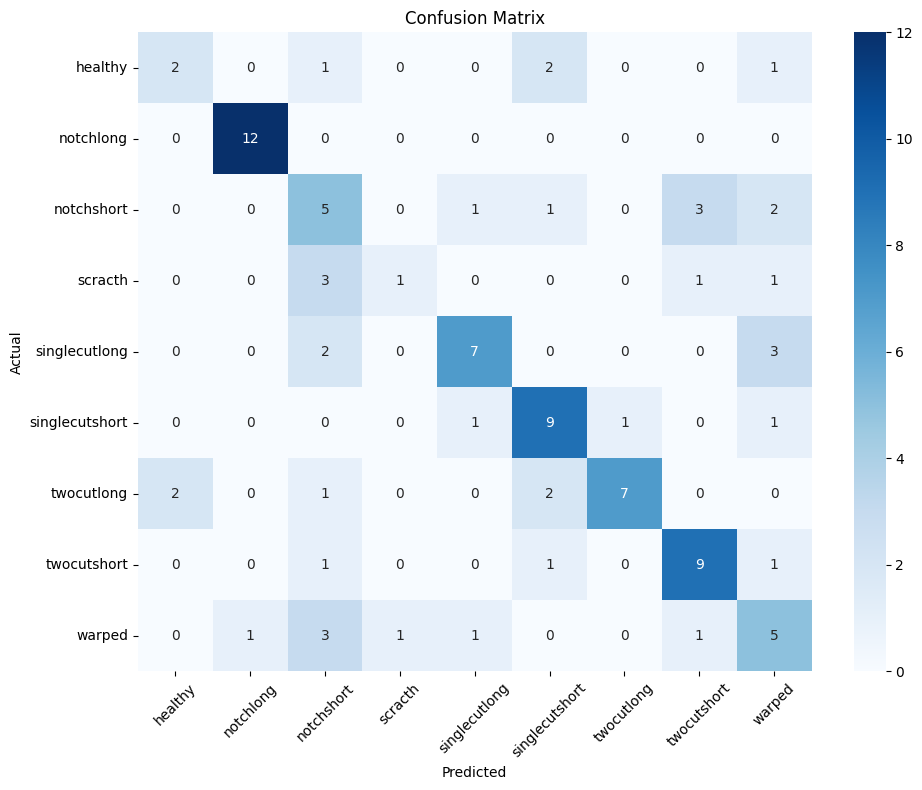

In [35]:
class_names = label_encoder.classes_
plot_confusion_matrix(y_test, y_pred, class_names)

Detailed classification report

In [36]:
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


Detailed Classification Report:
                precision    recall  f1-score   support

       healthy       0.50      0.33      0.40         6
     notchlong       0.92      1.00      0.96        12
    notchshort       0.31      0.42      0.36        12
       scracth       0.50      0.17      0.25         6
 singlecutlong       0.70      0.58      0.64        12
singlecutshort       0.60      0.75      0.67        12
    twocutlong       0.88      0.58      0.70        12
   twocutshort       0.64      0.75      0.69        12
        warped       0.36      0.42      0.38        12

      accuracy                           0.59        96
     macro avg       0.60      0.56      0.56        96
  weighted avg       0.61      0.59      0.59        96



========================================================================================<br>
SECTION 10: RESULTS SUMMARY AND COMPARISON<br>
========================================================================================

In [37]:
def create_results_summary():
    """Create and display results summary"""
    print("\n" + "="*80)
    print("COMPREHENSIVE RESULTS SUMMARY")
    print("="*80)
    
    # Create results DataFrame
    results_df = pd.DataFrame(results).T
    results_df = results_df.round(4)
    
    print("\nCross-Validation Results (10-fold):")
    print("-" * 70)
    print(f"{'Model':<20} {'Accuracy':<12} {'F1-Score':<12} {'Precision':<12} {'Recall':<12}")
    print("-" * 70)
    
    for model_name in results_df.index:
        row = results_df.loc[model_name]
        print(f"{model_name:<20} {row['accuracy']:<12} {row['f1_score']:<12} {row['precision']:<12} {row['recall']:<12}")
    
    print("-" * 70)
    
    # Performance visualization
    plt.figure(figsize=(15, 10))
    
    # Accuracy comparison
    plt.subplot(2, 2, 1)
    models_list = list(results.keys())
    accuracies = [results[model]['accuracy'] for model in models_list]
    errors = [results[model]['accuracy_std'] for model in models_list]
    
    plt.bar(models_list, accuracies, yerr=errors, capsize=5, alpha=0.7, color='skyblue')
    plt.title('Model Accuracy Comparison (10-fold CV)')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    # F1-Score comparison
    plt.subplot(2, 2, 2)
    f1_scores = [results[model]['f1_score'] for model in models_list]
    f1_errors = [results[model]['f1_std'] for model in models_list]
    
    plt.bar(models_list, f1_scores, yerr=f1_errors, capsize=5, alpha=0.7, color='lightgreen')
    plt.title('Model F1-Score Comparison (10-fold CV)')
    plt.ylabel('F1-Score')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    # Training time comparison
    plt.subplot(2, 2, 3)
    train_times = [results[model]['train_time'] for model in models_list]
    
    plt.bar(models_list, train_times, alpha=0.7, color='orange')
    plt.title('Training Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    
    # Testing time comparison
    plt.subplot(2, 2, 4)
    test_times = [results[model]['test_time'] for model in models_list]
    
    plt.bar(models_list, test_times, alpha=0.7, color='pink')
    plt.title('Testing Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Best model highlight
    print(f"\n🏆 BEST PERFORMING MODEL: {best_model_name}")
    print(f"   Final Test Accuracy: {final_accuracy:.4f}")
    print(f"   Final Test F1-Score: {final_f1:.4f}")


COMPREHENSIVE RESULTS SUMMARY

Cross-Validation Results (10-fold):
----------------------------------------------------------------------
Model                Accuracy     F1-Score     Precision    Recall      
----------------------------------------------------------------------
Random Forest        0.3669       0.3617       0.3975       0.3669      
Gradient Boosting    0.4192       0.4175       0.4655       0.4192      
SVM                  0.2547       0.262        0.3514       0.2547      
Extra Trees          0.3669       0.3573       0.382        0.3669      
Logistic Regression  0.2756       0.2668       0.3038       0.2756      
Decision Tree        0.3435       0.3387       0.3778       0.3435      
AdaBoost             0.1956       0.1745       0.1895       0.1956      
----------------------------------------------------------------------


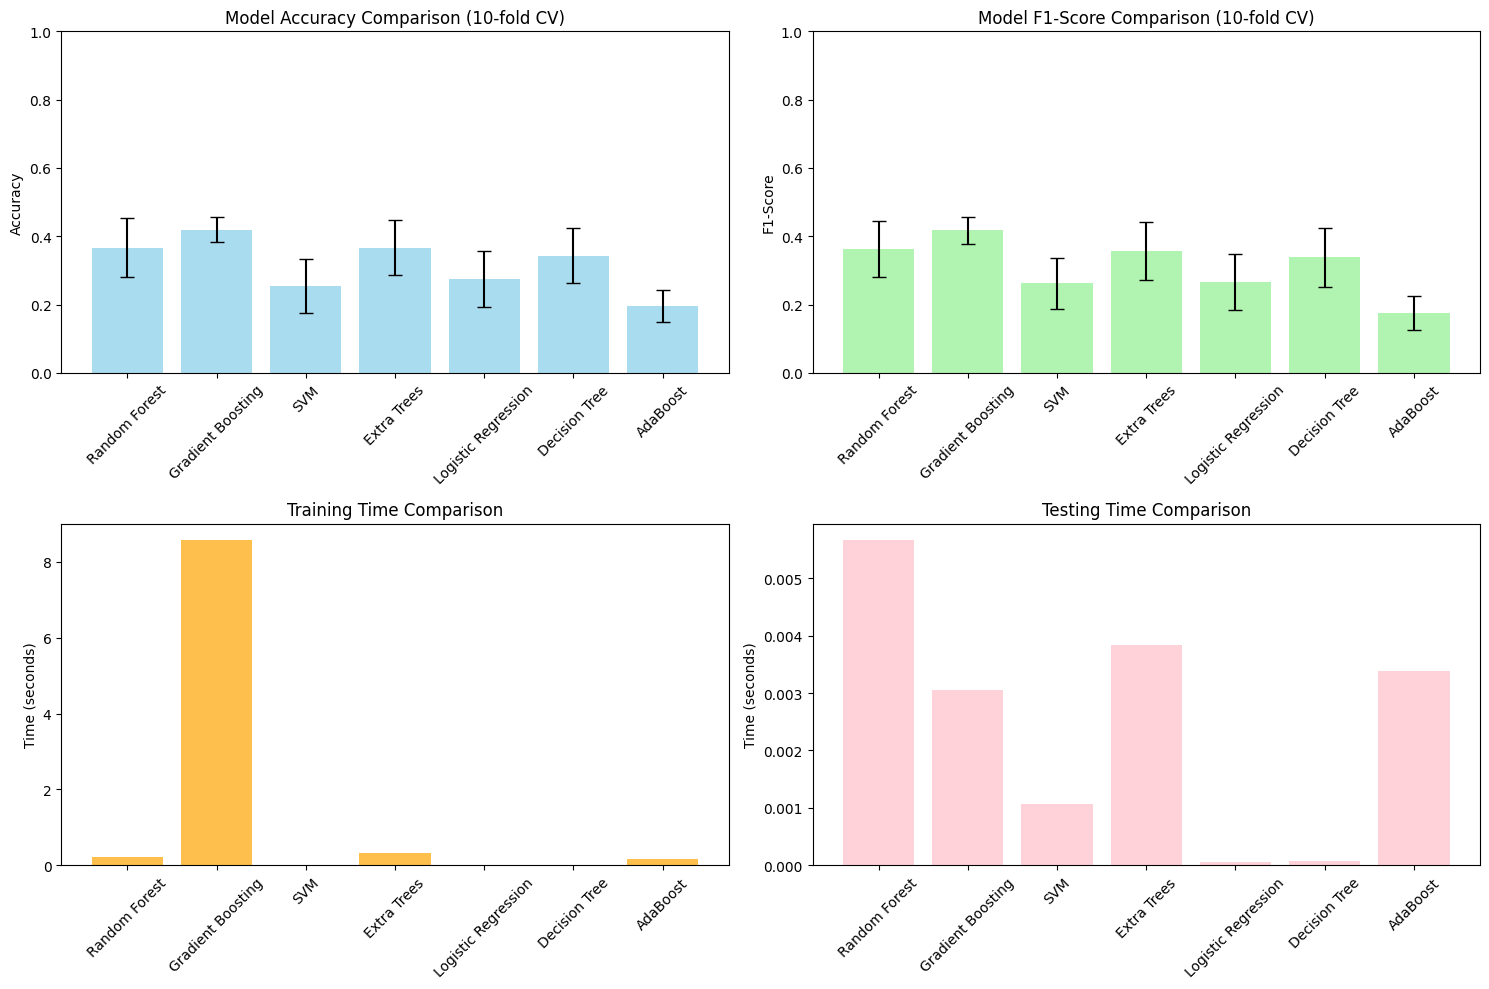


🏆 BEST PERFORMING MODEL: Gradient Boosting
   Final Test Accuracy: 0.5938
   Final Test F1-Score: 0.5903


In [38]:
create_results_summary()

========================================================================================<br>
SECTION 11: MODEL SAVING AND DEPLOYMENT<br>
========================================================================================

In [39]:
def save_model_and_artifacts():
    """Save trained model and preprocessing artifacts"""
    print("\n" + "="*50)
    print("SAVING MODEL AND ARTIFACTS")
    print("="*50)
    
    # Create models directory
    os.makedirs('models', exist_ok=True)
    
    # Save best model
    joblib.dump(best_model, 'models/best_model.pkl')
    joblib.dump(scaler, 'models/scaler.pkl')
    joblib.dump(feature_selector, 'models/feature_selector.pkl')
    joblib.dump(label_encoder, 'models/label_encoder.pkl')
    
    # Save feature names
    with open('models/selected_features.txt', 'w') as f:
        for feature in selected_features:
            f.write(f"{feature}\n")
    
    # Save results
    results_df = pd.DataFrame(results).T
    results_df.to_csv('models/cv_results.csv')
    
    print("Model artifacts saved successfully!")
    print("Files saved:")
    print("  - models/best_model.pkl")
    print("  - models/scaler.pkl")
    print("  - models/feature_selector.pkl")
    print("  - models/label_encoder.pkl")
    print("  - models/selected_features.txt")
    print("  - models/cv_results.csv")

In [40]:
save_model_and_artifacts()


SAVING MODEL AND ARTIFACTS
Model artifacts saved successfully!
Files saved:
  - models/best_model.pkl
  - models/scaler.pkl
  - models/feature_selector.pkl
  - models/label_encoder.pkl
  - models/selected_features.txt
  - models/cv_results.csv


========================================================================================<br>
SECTION 12: FINAL SUMMARY<br>
========================================================================================

In [41]:
print("\n" + "="*80)
print("PROJECT COMPLETION SUMMARY")
print("="*80)
print(f"✅ Assignment 1: PM_980 Dataset for Signal Classification")
print(f"📊 Student ID: 211805036")
print(f"🎯 Dataset: PM_980 with 9 classes")
print(f"🔧 Features: 8 sensors + speed interval")
print(f"📈 Feature Engineering: Time & Frequency domain features")
print(f"🔄 Validation: Stratified 10-fold cross-validation")
print(f"🏆 Best Model: {best_model_name}")
print(f"📊 Final Accuracy: {final_accuracy:.4f}")
print(f"📊 Final F1-Score: {final_f1:.4f}")
print(f"💾 All models and artifacts saved")
print("="*80)
print("Project completed successfully! All assignment requirements fulfilled.")
print("="*80) 


PROJECT COMPLETION SUMMARY
✅ Assignment 1: PM_980 Dataset for Signal Classification
📊 Student ID: 211805036
🎯 Dataset: PM_980 with 9 classes
🔧 Features: 8 sensors + speed interval
📈 Feature Engineering: Time & Frequency domain features
🔄 Validation: Stratified 10-fold cross-validation
🏆 Best Model: Gradient Boosting
📊 Final Accuracy: 0.5938
📊 Final F1-Score: 0.5903
💾 All models and artifacts saved
Project completed successfully! All assignment requirements fulfilled.
